# Импортируем библиотеки и скачаем архив с фотографиями

In [2]:
import torch
import torch.nn as nn
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda:0')

In [11]:
# pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=d0b73fb6d88626ea953c09f0137363d7ad3880cda2f8f1beaa90440db2ee8dd8
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [12]:
import wget

In [13]:
# url = 'http://sereja.me/f/universum_compressed.tar'
# wget.download(url)

'universum_compressed.tar'

In [14]:
# !tar xf universum_compressed.tar

In [15]:
device = torch.device('cuda:0')

# Колоризация изображений

In [16]:
import os
from PIL import Image

class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass
                #print('Could not load image:', filename)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y

In [17]:
transform_all = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

def to_grayscale(x):
    return 1 - (x[0] * 0.299 + x[1] * 0.587 + x[2] * 0.114).view(1, 128, 128)

In [18]:
dataset = ColorizationDataset('universum-photos', to_grayscale, transform_all)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:01<00:00, 722.84it/s]


In [19]:
for X, y in loader:
    print(X.shape, y.shape)
    break

torch.Size([64, 1, 128, 128]) torch.Size([64, 3, 128, 128])


### Класс Colorizer

In [20]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.preconcat = nn.Sequential(
            
            nn.Conv2d(1, 64, (3, 3), padding=1), 
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
#             nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, (3, 3), padding=1), 
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
#             nn.BatchNorm2d(128),
            
            nn.Conv2d(128, 256, (3, 3), padding=1), 
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
#             nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 512, (3, 3), padding=1), 
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            nn.ReLU(),
#             nn.BatchNorm2d(512),
            
            ######################## много-много таких штук ещё сделайте
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(512, 256, (3, 3), padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, (3, 3), padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, (3, 3), padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2)
        )
        
        
        self.postconcat = nn.Sequential(
            nn.Conv2d(65, 32, (3, 3), padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
#         print(x.shape)
        h = self.preconcat(x)
#         print(h.shape)
        h = torch.cat((h, x), 1)
        h = self.postconcat(h)
        return h

In [21]:
def to_numpy_image(img):
    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

In [22]:
def plot(x, y):
    img_gray, img_true = x, y
    img_pred = model(img_gray.to(device).view(1, 1, 128, 128))
    img_pred = to_numpy_image(img_pred)
    plt.figure(figsize=(10,10))
    
    plt.subplot(141)
    plt.axis('off')
    plt.set_cmap('Greys')
    plt.imshow(img_gray.reshape((128, 128)))

    plt.subplot(142)
    plt.axis('off')
    plt.imshow(img_pred.reshape((128, 128, 3)))

    plt.subplot(143)
    plt.axis('off')
    plt.imshow(to_numpy_image(img_true))
    
    plt.show()

In [23]:
model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

In [24]:
# print(model)

### Обучим получившуюся модель

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0: 0.013954311609268188


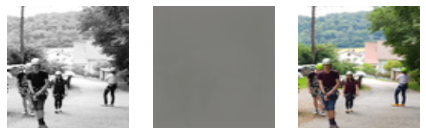

Epoch 20: 0.003731200471520424


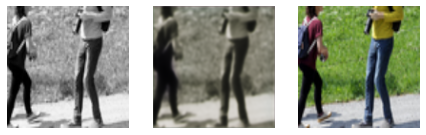

Epoch 40: 0.003512058174237609


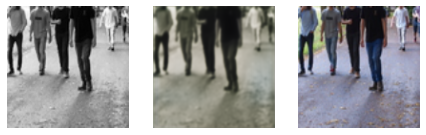

Epoch 60: 0.0029614665545523167


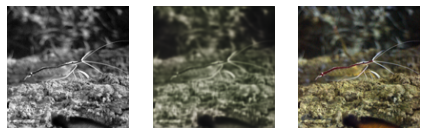

Epoch 80: 0.00284961867146194


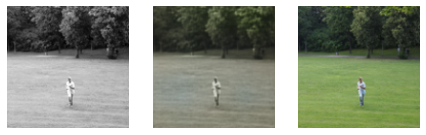

Epoch 99: 0.0026550525799393654


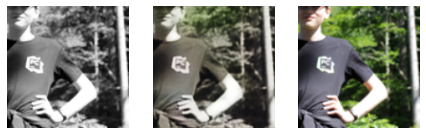

In [25]:
num_epochs = 100
history = []
for epoch in range(num_epochs):
    sum_loss = 0
    i = 0
    for x, y in loader:
        model.train()

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)
        sum_loss += loss.item()

        loss.backward()
        optimizer.step()

        model.eval()
        if (epoch in [0, 20, 40, 60, 80, 99]) and (i == 0):
            print(f'Epoch {epoch}: {sum_loss / len(loader)}')
            plot(x.cpu()[0], y.cpu()[0])
            i += 1

        del x
        del y
        torch.cuda.empty_cache()

    epoch_loss = sum_loss / len(loader)
    history.append(epoch_loss)
#     if epoch % 10 == 0:
#         print(f'epoch {epoch}: {sum_loss / len(loader)}')

### Протестируем обученную модель

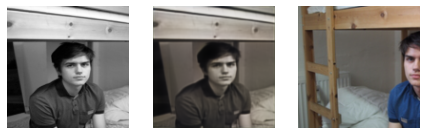

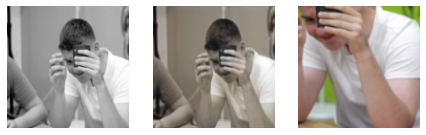

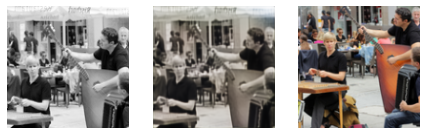

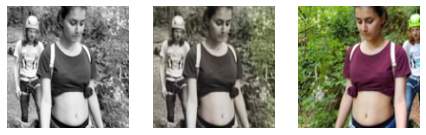

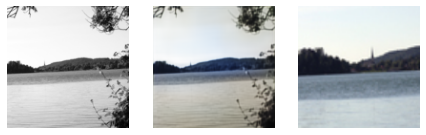

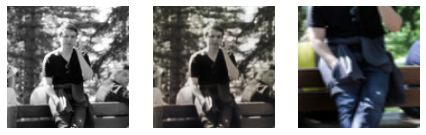

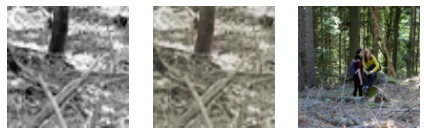

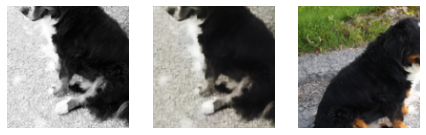

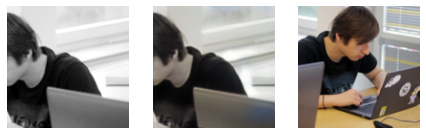

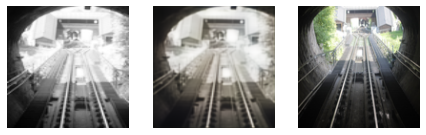

In [30]:
for i in [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    plot(dataset[i][0], dataset[i][1])